<a href="https://colab.research.google.com/github/RodrigoAVargasHdz/steady_state_jax/blob/main/energy_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 #@title Imports & Utils

from functools import partial

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import jax
import jax.numpy as jnp
from jax import custom_vjp, jit, grad, vmap, vjp, value_and_grad, jacrev
from jax import tree_multimap

from jax.experimental.ode import odeint
from jax.numpy.linalg import solve

from jax.config import config
config.update("jax_enable_x64", True)


# Title: Fully differentiable optimization protocols for non-equilibrium steady states

**authors**: Rodrigo A. Vargas-Hernández, Ricky T. Q. Chen, Kenneth A. Jung, Paul Brumer



# Introduction

In this tutorial we present the possibility to compute the gradient of a steady state using implicint differentiation. For more details about the work please consult [arXiv:2103.12604](https://arxiv.org/abs/2103.12604)

The system considered here is a minimal model of biological energy transfer. (donor-acceptor model)  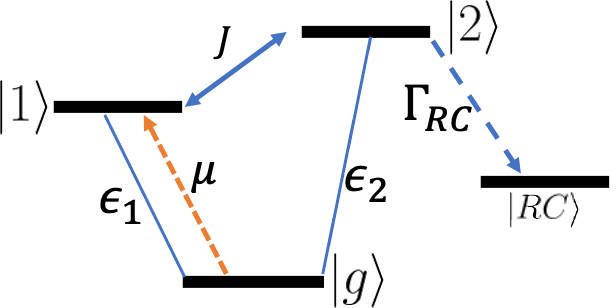

where the donor state $|1>$ is perturbed by incogeren radiation, for example sunlight. The state $|2>$ is acceptor that serves as a bridge with the Reactin Center $|RC>$ where the energy is absorved by the system. 
$J$ is the hopping coefficients between $|1>$ and $|2>$, and $\epsilon_i$ are the energy difference between the ground state $|g>$ and the $|i>$ state. 

## Quamtum Master Equation

The time evolution of this system is
modeled by,
\begin{eqnarray}
\frac{\partial \rho_{S}}{\partial t} = {\cal L}_{0}[\rho_{S}] + {\cal L}_{rad}[\rho_{S}] + {\cal L}_{deph}[\rho_{S}] + {\cal L}_{rec}[\rho_{S}] + {\cal L}_{RC}[\rho_{S}],
\end{eqnarray}
where the first term is the unitary evolution of the system, ${\cal L}_{0}[\rho] = -i \left [ H_{S}, \rho \right ]$, and the rest of the terms, ${\cal L}_i$, describe the radiation (rad), the trapping of the excitons at the reaction center (RC), environmental dephasing (deph), and the recombination of the excitons (rec). See [arXiv:2103.12604](https://arxiv.org/abs/2103.12604) and [J. Chem. Phys. 153, 114102 (2020)](https://doi.org/10.1063/5.0020576) for more information. 

The total master equation for this system is given by,
\begin{eqnarray}
\dot{\rho}_{e_{+}e_{+}} & = & -[2\Gamma + \gamma_d\sin^2(2\theta)+2\Gamma_{RC}\cos^2(\theta)]\rho_{e_{+}e_{+}} \nonumber  \\ 
& & +\gamma_d\sin^2(2\phi)\rho_{e_{-}e_{-}} + r_{e_{+}}\rho_{gg} \nonumber  \\ 
& & +[\Gamma_{RC}\sin(2\phi) - 2\gamma_d\sin(2\theta)\cos(2\phi)]\rho^{R}_{e_+e_-}, \nonumber \\
\dot{\rho}_{e_{-}e_{-}} & = & -[2\Gamma + \gamma_d\sin^2(2\theta)+2\Gamma_{RC}\sin^2(\theta)]\rho_{e_{-}e_{-}}\nonumber  \\ 
& & +\gamma_d\sin^2(2\theta)\rho_{e_{+}e_{+}} + r_{e_{-}}\rho_{gg} \nonumber  \\ 
& & +[\Gamma_{RC}\sin(2\theta) + 2\gamma_d\sin(2\theta)\cos(2\theta)]\rho^{R}_{e_+e_-}, \nonumber  \\
\dot{\rho}^{R}_{e_{+}e_{-}} & = & -[2\Gamma + \Gamma_{RC} + 2\gamma_d(1-\sin^2(2\theta))]\rho^{R}_{e_{+}e_{-}}\nonumber \\ 
& & +\Delta{\rho}^{I}_{e_{+}e_{-}} + \sqrt{r_{e_{+}} r_{e_{-}}}\rho_{gg} \nonumber \\
& & +\frac{1}{2}\Gamma_{RC}\sin(2\theta)(\rho_{e_{+}e_{+}} + \rho_{e_{-}e_{-}}) \nonumber \\
& & + \gamma_d\sin(2\theta)\cos(2\theta)(\rho_{e_-{e_-}}-\rho_{e_+{e_+}}),\nonumber \\
\dot{\rho}^{I}_{e_{+}e_{-}} & = & -[2\Gamma + 2\gamma_d + \Gamma_{RC}]\rho^{I}_{e_{+}e_{-}}  -\Delta\rho^{R}_{e_{+}e_{-}} ,
\end{eqnarray}
where $\dot{\rho}_{i,j}$ is the time derivative for one of the elements of the density matrix ($\rho_{S}$). $e_{+}$ and $e_{-}$ are eigen states of the bare system Hamiltonian $H_{S}$. 
$r_{+} = 2r\cos^2(\theta)$ and $r_{-} = 2r\sin^2(\theta)$, and $\tan(2\theta) = 2J/(\epsilon_1-\epsilon_2)$. 

The time evolution of $\rho_{S}$ depends on multiple parameters

*   (Bare system) ${\cal L}_{0}$ $\to$ $|\epsilon_1 - \epsilon_2|$, and $J$
*   (Light-matter interaction) ${\cal L}_{rad}$ $\to$ $r$
*   (trapping of the excitons at the RC) ${\cal L}_{RC}$ $\to$ $\Gamma_{RC}$
*   (environmental dephasing) ${\cal L}_{deph}$ $\to$ $\gamma_d$






# Implicit differentiation

In the steady state limit ($\dot{\rho} = 0$), the Liuovilian ($F(\cdot)$) is equal to zero,
\begin{eqnarray}
F(\rho_{ss}, \boldsymbol{\Theta}) = 0,
\end{eqnarray}
where $\boldsymbol{\Theta}$ are all parameters in the master equation.
Implicitily, the steady state depends on the $\boldsymbol{\Theta}$ parameters; $\rho_{ss} = f(\boldsymbol{\Theta})$. 

The **GOAL** of this toturial is to show how to compute $\frac{\partial \rho_{ss}}{\partial \Theta_i}$. 

If we were able to compute $\frac{\partial \rho_{ss}}{\partial \Theta_i}$, what could we do?


*   Sensitivity analysis
*   Inverse desing of non-equilibrium steady state systems




Conditioned on a given set of parameters $\boldsymbol{\Theta}_0$, we denote $\rho^{ss}$ as the solution that satisfies the above equation.
By differentiating with respect to $\boldsymbol{\Theta}_0$ and evaluating at the point $(\rho_{ss},\boldsymbol{\Theta}_0)$ we get,
\begin{eqnarray}
\frac{\partial F(\rho_{ss},\boldsymbol{\Theta}_0)}{\partial \boldsymbol{\Theta}_0} + \frac{\partial  F(\rho_{ss},\boldsymbol{\Theta}_0)}{\partial \rho_{ss}} \frac{\partial \rho_{ss}}{\partial \boldsymbol{\Theta}_0}  = 0.
\end{eqnarray}
We can re-arrange this equation and obtain an expression for the term of interest:
\begin{eqnarray}
\frac{\partial \rho_{ss}}{\partial \boldsymbol{\Theta}_0} = - \Bigg[\frac{\partial  F(\rho_{ss},\boldsymbol{\Theta}_0)}{\partial \rho_{ss}}  \Bigg]^{-1}\frac{\partial F(\rho_{ss},\boldsymbol{\Theta}_0)}{\partial \boldsymbol{\Theta}_0}.
\end{eqnarray}
Any of the terms in the above Equatin can be computed exactly with AD. 
In other words, given an $\boldsymbol{\Theta}_0$ no matter how we solve for $\rho^{ss}$, we can still compute the Jacobian using just derivative information at the solution point $\boldsymbol{\Theta}_0$.

Usually $\rho_{ss}$ is solved by using a ODE solver to propagate $\rho(t)$ to large times, where $|\rho(t) -\rho(t_{+1}) | = 0$.

By using the **implicit function theorem** the computation of $\frac{\partial \rho_{ss}}{\partial \boldsymbol{\Theta}}$ is agnostic to how the steady state is solved, and avoids differentiating through the ODE solver. The memory cost is thus constant and does not scale with the complexity of the problem. 

Here we use JAX as the automatic differentiation library to compute all required derivatives. 

## Custom derivatives for the steady satate
Next we use the implicit function theorem to compute the Jacobian of $\rho_{ss}$

For any function, JAX permits us to define custom vector-Jacobian and Jacobian-vector products for use in automatic differentiation.

In [ ]:
@partial(custom_vjp, nondiff_argnums=(0, 3, 4))
def fixed_point(f, a, x0, atol, rtol):
    _f = f(a)

    def odefunc(y, t, *args):
        return _f(y) - y

    sols = odeint(odefunc, x0, jnp.linspace(0, 200000, 2), atol=atol, rtol=rtol) #ODE solver to long times
    return sols[-1]

# Foward pass
def fixed_point_fwd(f, a, x0, atol, rtol):
    out = fixed_point(f, a, x0, atol, rtol)
    return out, (out, a, x0)

# Backward pass
def fixed_point_bwd(f, atol, rtol, res, g):
    ans, a, x0 = res

    def rev_iter(params):
        a, x_star, x_star_bar = params
        _, vjp_x = vjp(f(a), x_star)
        return lambda g: vjp_x(g)[0] + x_star_bar

    _, vjp_a = vjp(lambda x: f(x)(ans), a)
    return vjp_a(fixed_point(rev_iter, (a, ans, g), jnp.zeros_like(x0), atol, rtol))[0], None

fixed_point.defvjp(fixed_point_fwd, fixed_point_bwd)

# Simulations

Here we preent two different uses for $\frac{\partial \rho_{ss}}{\partial \Theta_i}$


*   Sensitivity analysis
*   Inverse desing of non-equilibrium steady state systems

## Sensitvity analysis

Her we illustrate how the pumping rate $r$ affects the steady satate by doing a sensitivty analysis. 



### Quantum Master Equation
Using the model described in the [Introduction](#Introduction) we used JAX to compute $\frac{\partial \rho_{ss}}{\partial \boldsymbol{\Theta}}$.

For simplisty we can notice that the evolution of $\rho$ can be described as,
\begin{eqnarray}
\frac{d \rho}{d t} = A \rho + b,
\end{eqnarray}
where $\rho = [\rho_{e_{+}e_{+}},\rho_{e_{-}e_{-}},\rho^{R}_{e_{+}e_{-}},\rho^{I}_{e_{+}e_{-}}]$.

Fucnttions: ``` build_A ``` and ``` build_b ``` are used to construct the matrix and the vector $A$ and $b$.




In [ ]:
def build_A():
	
    gamma_plus = 2 * gamma + 2 * gamma_RC * jnp.cos(theta)**2
    gamma_minus = 2 * gamma + 2 * gamma_RC * jnp.sin(theta)**2
    gamma_RC_star = kappa * gamma_RC * jnp.sin(2 * theta)
    gamma_s = 2 * gamma + gamma_RC + 2 * gamma_d
    gamma_d_star = gamma_d * jnp.sin(2 * theta) * jnp.cos(2 * theta)
    d = gamma_d * jnp.sin(2 * theta)**2

    a00 = -(gamma_plus + d)
    a01 = d
    a02 = gamma_RC_star - 2 * gamma_d_star
    a03 = 0.0#jnp.zeros(1)#
    
    a10 = d
    a11 = -(gamma_minus + d)
    a12 = gamma_RC_star + 2 * gamma_d_star
    a13 = 0.0#

    a20 = 0.5 * (gamma_RC_star - 2 * gamma_d_star)
    a21 = 0.5 * (gamma_RC_star + 2 * gamma_d_star)
    a22 = -gamma_s + 2 * d
    a23 = Delta
    

    a30 = 0.0#jnp.zeros(1)#
    a31 = 0.0#jnp.zeros(1)#
    a32 = -Delta
    a33 = -gamma_s
    a0 = jnp.stack([a00, a01, a02, a03]).flatten()
    a1 = jnp.stack([a10, a11, a12, a13]).flatten()
    a2 = jnp.stack([a20, a21, a22, a23]).flatten()
    a3 = jnp.stack([a30, a31, a32, a33]).flatten()

    A = jnp.stack([a0, a1, a2, a3], axis=0)

    return A


In [ ]:

def build_b(log_r):
    r = jnp.exp(log_r)
    r_eplus = 2 * r * jnp.sin(theta)**2
    r_eminus = 2 * r * jnp.cos(theta)**2
    b = jnp.stack([r_eplus, r_eminus, jnp.sqrt(r_eplus * r_eminus), 0.], axis=0)
    return b.flatten()

### Steady state solver 
Then we define a function to solve for the steady state, $\rho_{ss}$

In [ ]:
@jit
def steady_state_fixed_point(params):
#     initial state
    x0 = jnp.ones(4)#jnp.array([1/jnp.sqrt(2),1/jnp.sqrt(2),0.,0.])

    def f(params):

        A = build_A()
        b = build_b(params)

        def odefunc(y): #Liouvillian
            return jnp.matmul(A, y) + b

        return lambda y: y + odefunc(y)

    return fixed_point(f, params, x0, atol=1e-14, rtol=1e-14)

Extra parameters for the simulation

---



In [ ]:
gamma_RC = 0.5
kappa = 1.0
# r = 6.34e-10
J = 0.12
d_e12 = 1.3
gamma = 5E-4
gamma_d = 1. #1E12 Hz
theta = 0.5 * jnp.arctan2(2 * J, d_e12)
Delta = jnp.sqrt(jnp.power(d_e12, 2) + jnp.power(2 * J, 2))

### Results

Sensitivity analyisis for the pumping rate $r$

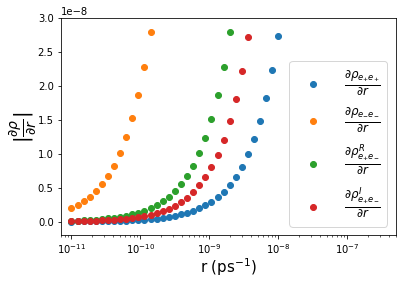

In [ ]:
    loss_all = jnp.zeros(1)
    log_r = jnp.log(10**jnp.linspace(-11, -8, 35))
    r_ = jnp.exp(log_r)

    grad_rho_ss = vmap(jacrev(steady_state_fixed_point))(log_r)

    label_grad_ = [r'$\frac{\partial \rho_{e_{+}e_{+}}}{\partial r}$',r'$\frac{\partial \rho_{e_{-}e_{-}}}{\partial r}$',
             r'$\frac{\partial \rho^{R}_{e_{+}e_{-}}}{\partial r}$',r'$\frac{\partial \rho^{I}_{e_{+}e_{-}}}{\partial r}$']

    fig1, ax1 = plt.subplots(1, sharex=True)


    for i in range(4):
        # y = jnp.abs(rho_ss[:,i])
        dy = jnp.abs(grad_rho_ss[:,i])
        ax1.scatter(r_,dy,label=label_grad_[i])

    ax1.set_xscale("log")    


    ax1.set_ylabel(r'$\left |\frac{\partial \rho}{\partial r}\right |$',fontsize=20,labelpad=0)
    ax1.set_xlabel(r'r (ps$^{-1}$)',fontsize=15,labelpad=0)

    plt.xlim(7e-12, 5e-7)
    plt.ylim(-2E-9,3e-8)
    plt.legend(fontsize = 17,loc=4)
    plt.show() 

## Inverse desging as an optimization problem

In general, any physical observable that depends on the steady state is a scalar function, \eg $f(\rho_{ss}, \boldsymbol{\Theta}) = \langle \hat{O} \rangle_{\rho_{ss}}$, whose gradient with respect to the parameters can be decomposed with the chain rule,
\begin{eqnarray}
\frac{\partial f(\rho_{ss}, \boldsymbol{\Theta})}{\partial \Theta_i} = \frac{\partial \; \langle \hat{O}(\boldsymbol{\Theta}) \rangle_{\rho_{ss}}}{\partial \Theta_i} = \texttt{Tr}\left [ \left ( \frac{\partial \;\hat{O}(\boldsymbol{\Theta})}{\partial \Theta_i} \right )\rho_{ss} + \hat{O}(\boldsymbol{\Theta}) \left (\frac{\partial \; \rho_{ss} }{\partial \Theta_i} \right ) \right ],% =  \texttt{Tr}\left [ \frac{\partial }{\partial \boldsymbol{\Theta}} \left [\hat{O}(\boldsymbol{\Theta}) \rho_{ss} \right ]\right ]
\end{eqnarray}
where terms of the form $\frac{\partial \;\hat{O}(\boldsymbol{\Theta})}{\partial \boldsymbol{\Theta}}$ can be computed efficiently with automatic differentiation \cite{AD_survey}, or using closed form expressions when available.
On the other hand, the gradient of the steady state with respect to some parameters, $\frac{d\rho_{ss}}{d \boldsymbol{\Theta}}$, could be computed with the methodology presented in this colab.

**GOAL:** Find the values of $\boldsymbol{\Theta}$ where a quantum observable is maximum by using gradient based method.

Here we use the **localization efficiency** $(\eta_{loc})$ to quantify the transport efficiency for this system.


In [ ]:
@jit
def obj_fixed_point(params):
    ss = steady_state_fixed_point(params)
    loss =  jnp.cos(theta)**2 * ss[0] + jnp.sin(theta)**2 * ss[1]
    loss = loss + -2*jnp.sin(theta)*jnp.cos(theta)*ss[2]
    return (gamma_RC / r)*loss    

### Liuovillian and Steady state solver

In [ ]:
# Extra parameters

gamma_RC = 0.5
kappa = 1.0
r = 6.34e-10
J = 0.12
d_e12 = 1.3

theta = 0.5 * jnp.arctan2(2 * J, d_e12)
Delta = jnp.sqrt(jnp.power(d_e12, 2) + jnp.power(2 * J, 2))

In [ ]:
def build_A(params):
    log_gamma, log_gamma_d = params
	
    gamma_d = jnp.exp(log_gamma_d) * 1e-12
    gamma = jnp.exp(log_gamma)

    gamma_plus = 2 * gamma + 2 * gamma_RC * jnp.cos(theta)**2
    gamma_minus = 2 * gamma + 2 * gamma_RC * jnp.sin(theta)**2
    gamma_RC_star = kappa * gamma_RC * jnp.sin(2 * theta)
    gamma_s = 2 * gamma + gamma_RC + 2 * gamma_d
    gamma_d_star = gamma_d * jnp.sin(2 * theta) * jnp.cos(2 * theta)
    d = gamma_d * jnp.sin(2 * theta)**2

    a00 = -(gamma_plus + d)
    a01 = d
    a02 = gamma_RC_star - 2 * gamma_d_star
    a03 = jnp.zeros(1)#0.0

    a10 = d
    a11 = -(gamma_minus + d)
    a12 = gamma_RC_star + 2 * gamma_d_star
    a13 = jnp.zeros(1)#0.0

    a20 = 0.5 * (gamma_RC_star - 2 * gamma_d_star)
    a21 = 0.5 * (gamma_RC_star + 2 * gamma_d_star)
    a22 = -gamma_s + 2 * d
    a23 = Delta*jnp.ones(1)
    
    a30 = jnp.zeros(1)#0.0
    a31 = jnp.zeros(1)#0.0
    a32 = -Delta*jnp.ones(1)
    a33 = -gamma_s*jnp.ones(1)

    a0 = jnp.stack([a00, a01, a02, a03]).ravel()
    a1 = jnp.stack([a10, a11, a12, a13]).ravel()
    a2 = jnp.stack([a20, a21, a22, a23]).ravel()
    a3 = jnp.stack([a30, a31, a32, a33]).ravel()

    A = jnp.stack([a0, a1, a2, a3], axis=0)
    return A

In [ ]:
def build_b():
    r_eplus = 2 * r * jnp.sin(theta)**2
    r_eminus = 2 * r * jnp.cos(theta)**2
    b = jnp.stack([r_eplus, r_eminus, jnp.sqrt(r_eplus * r_eminus), 0.0])
    return b

In [ ]:
@jit
def steady_state_fixed_point(params):
#     initial state
    x0 = jnp.ones(4)#jnp.array([1/jnp.sqrt(2),1/jnp.sqrt(2),0.,0.])

    def f(params):

        A = build_A(params)
        b = build_b()

        def odefunc(y): #Liouvillian
            return jnp.matmul(A, y) + b

        return lambda y: y + odefunc(y)

    return fixed_point(f, params, x0, atol=1e-14, rtol=1e-14)

## Gradient descent


In [ ]:
def get_init_params(i):
    rng = jax.random.PRNGKey(i)
    rng, subkey = jax.random.split(rng)
    init_gamma_d = jax.random.uniform(subkey, (1,),minval=9.0, maxval=15.0)
    init_gamma_d = jnp.log(10**jnp.array(init_gamma_d))
    init_gamma = jax.random.uniform(subkey, (1,),minval=-2.0, maxval=-1.5)
    init_gamma = jnp.log(10**jnp.array(init_gamma))
    w = (init_gamma,init_gamma_d)
    return w

Maximization of $\eta_{loc}$ as a function of $\Gamma$ and $\gamma_d$.
At each iteration we update the parameters ($\mathbf{w}_t$) usnig,
\begin{eqnarray}
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \nabla\eta_{loc},
\end{eqnarray}
where $\alpha$ is the learning rate, and $\nabla\eta_{loc} = \left [\frac{\partial \eta_{loc}}{\partial \Gamma},\frac{\partial \eta_{loc}}{\partial \gamma_d}\right ]$

In [ ]:
i0 = 0 # random intenger for the sampling
params = get_init_params(0)
eta_loc = obj_fixed_point(params)

itr_eta = [eta_loc]
itr_params = [params]

# initial values
print('Inital values')
print(params,eta_loc)

#gradient acent
alpha = 0.5
itr = 0

inner_sgd_fn = lambda g, params: (params + alpha*g)

print('Iteration & eta_loc & gradients')
while eta_loc < 0.99:
    eta_loc, grads = value_and_grad(obj_fixed_point)(params)

    params = tree_multimap(inner_sgd_fn, grads, params)

    if itr%5 == 0:
      print(itr,eta_loc,jnp.exp(jnp.asarray(params).ravel()))

    itr_eta.append(eta_loc)
    itr_params.append(params)

    itr += 1

Inital values
(DeviceArray([-3.94139152], dtype=float64), DeviceArray([28.68860986], dtype=float64)) 0.09730249564399704
Iteration & eta_loc & gradients
0 0.09730325724020496 [1.85518847e-02 2.77602981e+12]
5 0.14289935045336327 [1.40471409e-02 2.23689634e+12]
10 0.22918909726245978 [9.47235487e-03 1.68521006e+12]
15 0.38333217300099 [5.49395077e-03 1.20440801e+12]
20 0.5766059853870112 [2.94391962e-03 8.94937196e+11]
25 0.7239028994885027 [1.69597181e-03 7.38590727e+11]
30 0.8104295219829174 [1.10378834e-03 6.59265483e+11]
35 0.8605095461203847 [7.91987999e-04 6.13966835e+11]
40 0.8914138021116371 [6.08243549e-04 5.85040734e+11]
45 0.9118492782963739 [4.89811261e-04 5.64956906e+11]
50 0.9261630942231283 [4.08129212e-04 5.50135620e+11]
55 0.9366619070796735 [3.48819936e-04 5.38692161e+11]
60 0.9446527633856753 [3.04004556e-04 5.29547669e+11]
65 0.9509187235363878 [2.69055802e-04 5.22041649e+11]
70 0.9559515738619682 [2.41098280e-04 5.15747277e+11]
75 0.9600722135903497 [2.18260301e-04 

To save time for plotting let's solve for the steady state using, 
\begin{eqnarray}
\rho_{ss} = - A^{-1}b
\end{eqnarray}

In [ ]:
def steady_state_matinv(params):
    A = build_A(params)
    b = build_b()
    return solve(-A, b)

def obj_matinv(params):
    ss = steady_state_matinv(params)
    loss =  jnp.cos(theta)**2 * ss[0] + jnp.sin(theta)**2 * ss[1]
    loss = loss + -2*jnp.sin(theta)*jnp.cos(theta)*ss[2]
    return (gamma_RC / r)*loss   

In [ ]:
# Grid for plotting the GA trajectories 

log_gamma_ds = jnp.log(10**jnp.linspace(8, 16, 15))
log_gamma_s = jnp.log(10**jnp.linspace(-1.5,-5.5, 15))

log_gamma_msh,log_gamma_d_msh = jnp.meshgrid(log_gamma_s,log_gamma_ds)
params_msh = jnp.stack([log_gamma_msh.flatten(),log_gamma_d_msh.flatten()],axis=1)

params_grid = [tuple((row[0]*jnp.ones(1),row[1]*jnp.ones(1))) for row in params_msh]
eta_loc_msh = []
for p in params_grid: 
  eta_tmp = obj_matinv(p)
  eta_loc_msh.append(eta_tmp)


Plotting Gradient ascent trajectory to maximize $\eta_{loc}$.


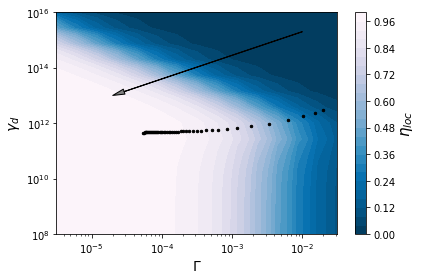

In [ ]:
    fig, ax = plt.subplots()
    z = jnp.asarray(eta_loc_msh).reshape(log_gamma_msh.shape)
    cs = ax.contourf(jnp.exp(log_gamma_msh),jnp.exp(log_gamma_d_msh), z, levels=30,cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)

    itr_eta.append(eta_loc)
    itr_params = jnp.asarray(itr_params)
    ax.scatter(jnp.exp(itr_params[::5,0]),jnp.exp(itr_params[::5,1]),c='k',marker='o',s=6)   


    plt.annotate('', xy=(2E-5, 1E13), xytext=(1E-2, 2E15), 
            arrowprops=dict(facecolor='grey', shrink=0.,width=0.2,headwidth=5.2),
            )
    
    cbar.ax.set_ylabel(r'$\eta_{loc}$',fontsize=15)
    ax.set_xlabel(r'$\Gamma$',fontsize=14)
    ax.set_ylabel(r'$\gamma_{d}$',fontsize=14)
    plt.yscale("log")
    plt.xscale("log")
    plt.tight_layout()